In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.021 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

250000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

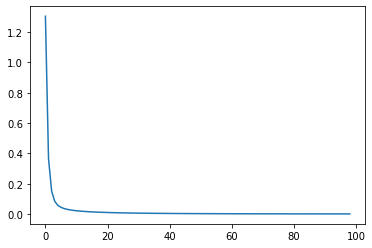

In [8]:
plt.plot(S)

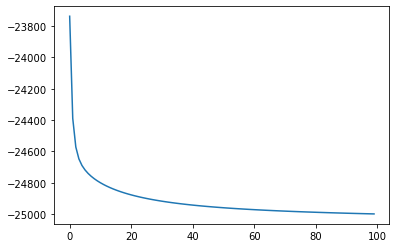

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0009333666278325836

In [11]:
eta

array([-23737.7614685 , -24389.6496134 , -24572.47912951, -24648.20283678,
       -24690.14922736, -24718.87566021, -24741.01981766, -24759.23346522,
       -24774.7973447 , -24788.42356166, -24800.55119833, -24811.47285057,
       -24821.39546575, -24830.47237602, -24838.82143753, -24846.5359331 ,
       -24853.69146034, -24860.35047208, -24866.56538075, -24872.38074929,
       -24877.83488136, -24882.96100385, -24887.78816567, -24892.34193395,
       -24896.64494254, -24900.71733071, -24904.57709861, -24908.24039884,
       -24911.72177802, -24915.03437887, -24918.19011065, -24921.19979399,
       -24924.07328476, -24926.81958073, -24929.44691379, -24931.96283016,
       -24934.37426049, -24936.68758132, -24938.9086691 , -24941.04294806,
       -24943.09543248, -24945.07076439, -24946.97324704, -24948.80687489,
       -24950.57536046, -24952.2821584 , -24953.93048717, -24955.52334855,
       -24957.06354527, -24958.553697  , -24959.99625477, -24961.39351412,
       -24962.74762698, -

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([1.26163853e+03, 6.09750387e+02, 4.26920871e+02, 3.51197164e+02,
       3.09250773e+02, 2.80524340e+02, 2.58380183e+02, 2.40166535e+02,
       2.24602656e+02, 2.10976439e+02, 1.98848802e+02, 1.87927150e+02,
       1.78004535e+02, 1.68927625e+02, 1.60578563e+02, 1.52864068e+02,
       1.45708540e+02, 1.39049529e+02, 1.32834620e+02, 1.27019251e+02,
       1.21565119e+02, 1.16438997e+02, 1.11611835e+02, 1.07058067e+02,
       1.02755058e+02, 9.86826699e+01, 9.48229020e+01, 9.11596018e+01,
       8.76782226e+01, 8.43656217e+01, 8.12098900e+01, 7.82002066e+01,
       7.53267158e+01, 7.25804199e+01, 6.99530868e+01, 6.74371704e+01,
       6.50257401e+01, 6.27124193e+01, 6.04913315e+01, 5.83570525e+01,
       5.63045681e+01, 5.43292362e+01, 5.24267536e+01, 5.05931257e+01,
       4.88246401e+01, 4.71178422e+01, 4.54695134e+01, 4.38766521e+01,
       4.23364553e+01, 4.08463036e+01, 3.94037458e+01, 3.80064865e+01,
       3.66523736e+01, 3.53393880e+01, 3.40656332e+01, 3.28293267e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_9.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_9.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_9.csv', S, delimiter = ',')